# Finding Sites at Risk of Wildfire with Convolutional Neural Networks

__Project Description:__ <br>
This notebook contains exploratory data analysis and the convolutional neural network model used to predict whether or not a location is susceptible to wildfires.  The data for this exploration consists of roughly 20,000 labeled satellite images. 10,000 of the images are locations which have experienced wildfires, while the other 10,000 have never seen a wildfire before.

While I was unable to collect satellite imagery of the site a few days before the fire, I believe this will suffice as a proof of concept, especially since areas that experience wildfires often experience them again.

# Importing Libraries:

In [1]:
import os
import shutil
import pandas as pd
import numpy as np

# Plots and Graphs
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
from matplotlib import image
import plotly.express as px
import scikitplot as skplt
import folium 
%matplotlib inline

import requests
import random
from IPython.display import Image, display

# API and Requests
import urllib.request

# Keras/Tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# Pillow
import PIL
from PIL import Image

# Other
import scipy
from scipy import ndimage

# Shows all columns
pd.set_option('display.max_columns', None)

# Turning off warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Importing Data:

Source: Washington State DNR [link](https://geo.wa.gov/datasets/wadnr::dnr-fire-statistics-2008-present-1/data?geometry=-126.579%2C45.325%2C-111.143%2C47.964&orderBy=FIRE_RGE_WHOLE_NO&orderByAsc=false&selectedAttribute=ACRES_BURNED)

In [2]:
df = pd.read_csv('DNR_Fire_Statistics_2008_-_Present.csv')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data for the EDA
df.head()

,X,Y,OBJECTID,FIREEVENT_ID,INCIDENT_NO,INCIDENT_NM,INCIDENT_ID,COUNTY_LABEL_NM,FIRE_TWP_WHOLE_NO,FIRE_TWP_FRACT_NO,FIRE_RGE_WHOLE_NO,FIRE_RGE_FRACT_NO,FIRE_RGE_DIR_FLG,FIRE_SECT_NO,SITE_ELEV,FIREGCAUSE_LABEL_NM,FIRESCAUSE_LABEL_NM,BURNESCAPE_RSN_LABEL_NM,ACRES_BURNED,START_DT,START_TM,DSCVR_DT,DSCVR_TM,CONTROL_DT,CONTROL_TM,FIRE_OUT_DT,FIRE_OUT_TM,BURN_MERCH_AREA,BURN_REPROD_AREA,BURN_NONSTOCK_AREA,FIREEVNT_CLASS_CD,FIREEVNT_CLASS_LABEL_NM,SECTION_SUBDIV_PTS_ID,LAT_COORD,LON_COORD,RES_ORDER_NO,NON_DNR_RES_ORDER_NO,START_OWNER_AGENCY_NM,START_JURISDICTION_AGENCY_NM,PROTECTION_TYPE,REGION_NAME
0,-1.313200e+07,6.266774e+06,3299,43191,1582,ELBOW LAKE,42924,STEVENS,40,0,38,0,E,22,0.0,Lightning,None,NaN,0.0,2015/08/11 08:00:00+00,1759,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,NaN,NaN,NaN,4,Other Agency,796320,48.95230,-117.96678,NaN,NaN,US Forest Service,US Forest Service,DNR Assist Other Agency,NORTHEAST
1,-1.315341e+07,6.247347e+06,7713,8762,288,TOULOU PATIENCE,8904,STEVENS,39,0,37,0,E,31,2600.0,Lightning,None,NaN,0.1,2009/07/25 08:00:00+00,30,2009/07/25 00:00:00+00,35.0,2009/07/26 00:00:00+00,1500.0,2009/07/30 00:00:00+00,1240.0,NaN,NaN,NaN,1,Classified,894036,48.83758,-118.15910,WA-NES-857,NaN,Private,DNR,DNR Protection FFPA,NORTHEAST
2,-1.319295e+07,6.258769e+06,20476,54457,51,SKIDMOORE,54310,STEVENS,39,0,34,0,E,4,1432.0,Miscellaneou,Power Line,NaN,0.1,2018/05/03 08:00:00+00,130,2018/05/03 00:00:00+00,942.0,2018/05/03 00:00:00+00,1200.0,2018/05/11 00:00:00+00,1248.0,0.1,NaN,NaN,1,Classified,821417,48.90506,-118.51425,NaN,NaN,Private,DNR,DNR Protection FFPA,NORTHEAST
3,-1.316664e+07,6.078592e+06,9554,28461,149,LYNN ROAD,28147,LINCOLN,27,0,36,0,E,21,2087.0,Lightning,None,NaN,5.0,2012/07/18 08:00:00+00,1200,2012/07/18 00:00:00+00,1200.0,2012/07/19 00:00:00+00,1500.0,2012/08/04 00:00:00+00,1353.0,NaN,NaN,NaN,1,Classified,324500,47.82983,-118.27793,WA-NES-526,NaN,DNR,DNR,DNR Protection FFPA,NORTHEAST
4,-1.365186e+07,5.768455e+06,15270,62780,144,BLUEBERRY HILL,62673,CLARK,5,0,1,0,E,12,101.0,Miscellaneou,Structure Fi,NaN,0.1,2019/10/19 08:00:00+00,1100,1970/01/01 00:00:00+00,NaN,2019/10/19 00:00:00+00,1600.0,2019/10/19 00:00:00+00,1600.0,NaN,NaN,NaN,1,Classified,574475,45.92572,-122.63673,WA-PCS-0263,NaN,Private,Joint DNR & WA Fire Service,DNR Protection FFPA,PACIFIC CASC


## Column Descriptions:

__Main Columns:__
                           
- __OBJECTID:__ Unique ID
- __FIREEVENT_ID:__ Unique ID
- __INCIDENT_NO:__ Incident Number
- __INCIDENT_NM:__ Incident Name (trail or forest area)
- __COUNTY_LABEL_NM:__ County Name (King, Stevens, etc. . .)          
- __SITE_ELEV:__ Elevation of site
- __FIREGCAUSE_LABEL_NM:__ Cause
- __FIRESCAUSE_LABEL_NM:__ Secondary cause
- __BURNESCAPE_RSN_LABEL_NM:__
- __ACRES_BURNED:__ Acres Burned
- __START_DT:__ Start Date
- __START_TM:__ Start Time
- __DSCVR_DT:__ Discovery Date
- __DSCVR_TM:__ Discovery Time
- __CONTROL_DT:__ Date brought under control
- __CONTROL_TM:__ Time brought under control
- __FIRE_OUT_DT:__ Date fire was put out
- __FIRE_OUT_TM:__ Time fire was put out
- __FIREEVNT_CLASS_LABEL_NM:__ 'Classified' or 'Other Agency'
- __LAT_COORD:__ Longitude
- __LON_COORD:__ Latitude
- __START_OWNER_AGENCY_NM:__ Owner of land where fire started (private, government, DNR, etc. . .)
- __START_JURISDICTION_AGENCY_NM:__ Jurisdiction where it started
- __PROTECTION_TYPE:__ Type of Protection of area
- __REGION_NAME:__  Region

## Images:

### Wildfire Area Image Previews:

__Image examples:__<br>
__Areas with wildfires:__
![text](example_images/wf1.jpg)
![text](example_images/wf2.jpg)
![text](example_images/wf3.jpg)

### Non-Wildfire Area Image Previews:

__Areas without wildfires:__
![text](example_images/nwf1.jpg)
![text](example_images/nwf2.jpg)
![text](example_images/nwf3.jpg)

# Cleaning:

In [3]:
# Fixing a spelling error:
df['FIREGCAUSE_LABEL_NM'] = df['FIREGCAUSE_LABEL_NM'].map(lambda x: 'Misc' 
                                                          if x == 'Miscellaneou' 
                                                          else x)

In [4]:
# Dealing with dates: 
df['date'] = pd.to_datetime(df.START_DT)
df.date = df.date.dt.strftime('%m/%d/%Y')
df['date'] = pd.to_datetime(df.date)
# Extracting Month
df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year

# Exploratory Data Analysis:

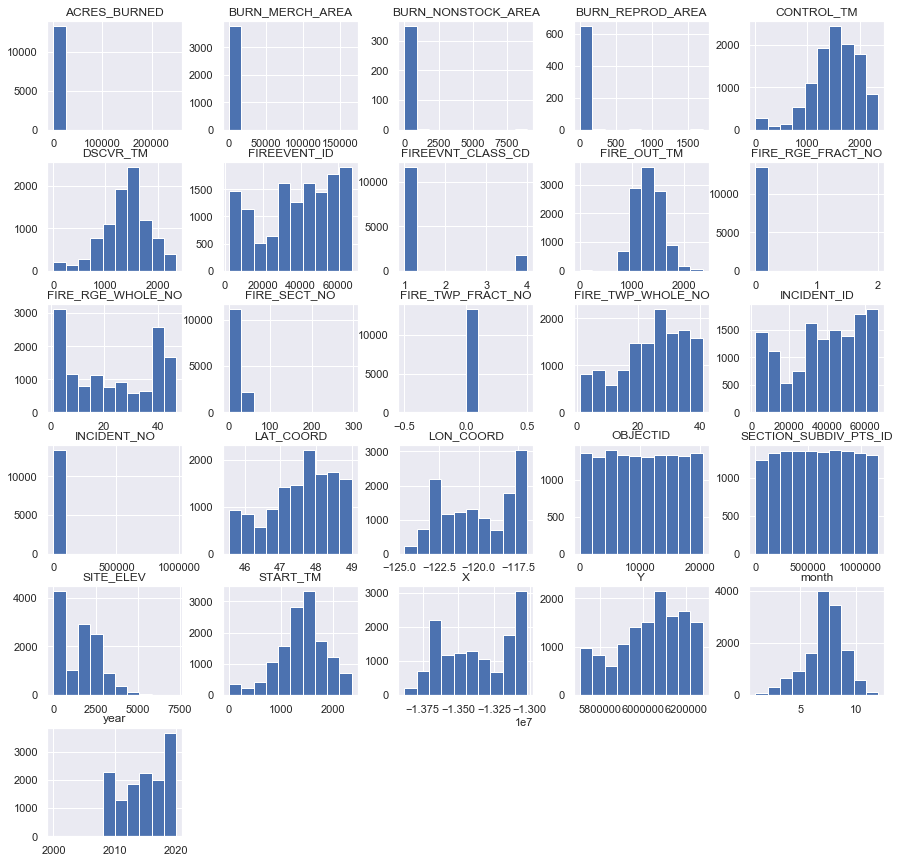

In [5]:
# Initial Histogram Plot
df.hist(figsize=(15,15));

## Bar Chart by Region: 

In [6]:
# Unique regions where fires occured:
print('Regions of Fires:\n\n', df.REGION_NAME.value_counts())

Regions of Fires:

 NORTHEAST       6447
SOUTHEAST       2557
PACIFIC CASC    1661
SO PUGET        1482
NORTHWEST        791
OLYMPIC          441
Name: REGION_NAME, dtype: int64


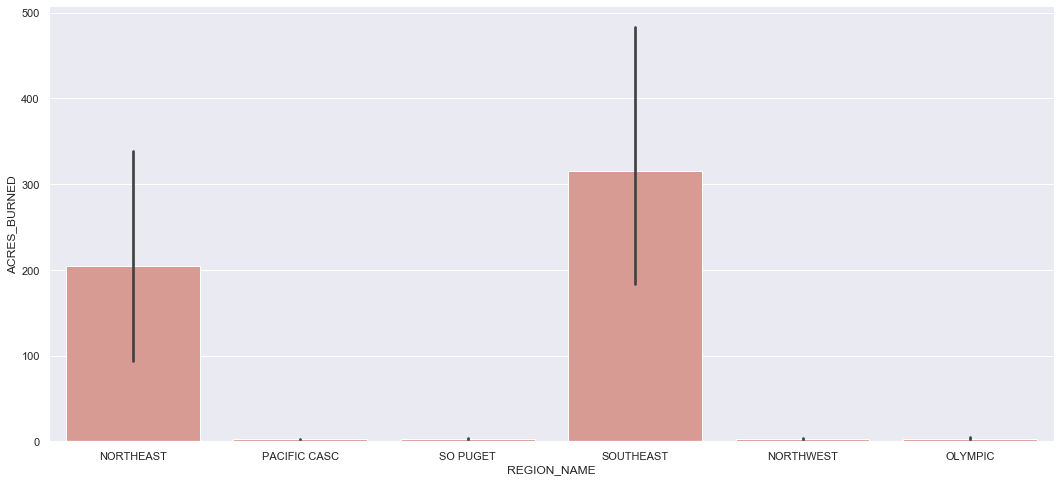

In [7]:
# Plotting the figure:
plt.figure(figsize = (18,8))
ax = sns.barplot(x="REGION_NAME", y="ACRES_BURNED", data=df,
                 color="salmon", saturation=.5)

There's not a lot of information here.  Let's try to get more granular.  

## Bar Chart by County:

In [8]:
print('Top 10 County of Fires:\n\n', df.COUNTY_LABEL_NM.value_counts()[:10])

Top 10 County of Fires:

 SPOKANE         2057
STEVENS         1782
OKANOGAN        1471
KLICKITAT        722
MASON            573
KITTITAS         565
THURSTON         559
CHELAN           485
FERRY            470
PEND OREILLE     467
Name: COUNTY_LABEL_NM, dtype: int64


In [9]:
ten_counties = ['SPOKANE', 'STEVENS', 'OKANOGAN', 'KLICKITAT', 'MASON', 
                'KITTITAS', 'THURSTON', 'CHELAN', 'FERRY', 'PEND OREILLE']
df['County'] = df['COUNTY_LABEL_NM'].map(lambda x: x if x in ten_counties 
                                             else 'Other')

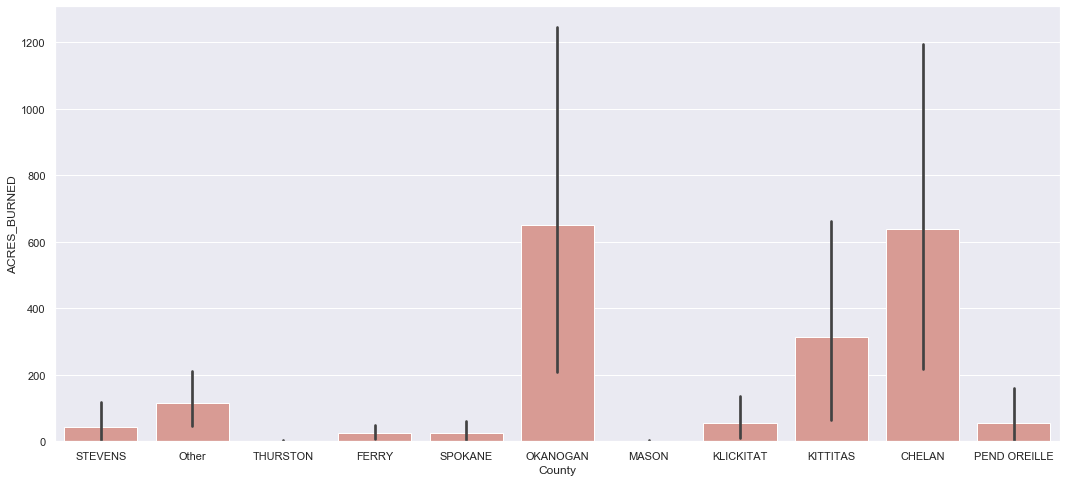

In [10]:
plt.figure(figsize = (18,8))
ax = sns.barplot(x="County", y="ACRES_BURNED", data=df,
                 color="salmon", saturation=.5)

## Elevation Histogram:

In [11]:
print('Minimum Elevation: ', min(df.SITE_ELEV))
print('Maximum Elevation: ', max(df.SITE_ELEV))

Minimum Elevation:  0.0
Maximum Elevation:  7287.0


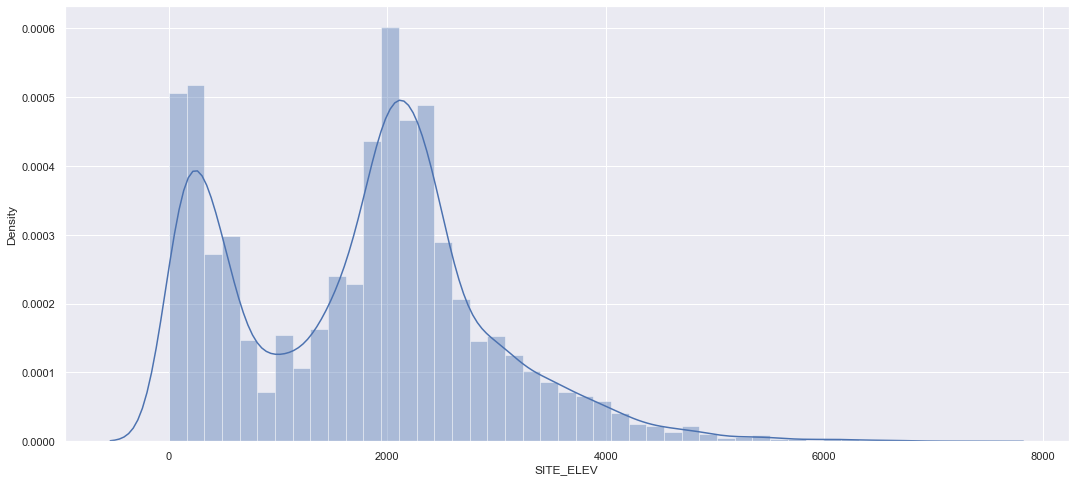

In [12]:
# Histogram of elevation for wildfires
# Most likely due to being clustered around two main sites. . . 
# I'd be interested to see where the high elevation fires are happening. . . 
# Especially the 8000 ft one!
plt.figure(figsize = (18,8))
dftest = df[df['SITE_ELEV'] > 0]
sns.distplot(dftest.SITE_ELEV);

## Map with Pins, Size by Acres:

In [13]:
print('Minimum Acres Burned: ', min(df.ACRES_BURNED))
print('Maximum Acres Burned: ', max(df.ACRES_BURNED))
# Change to > 0

Minimum Acres Burned:  0.0
Maximum Acres Burned:  250280.45


__Acre Histograms:__

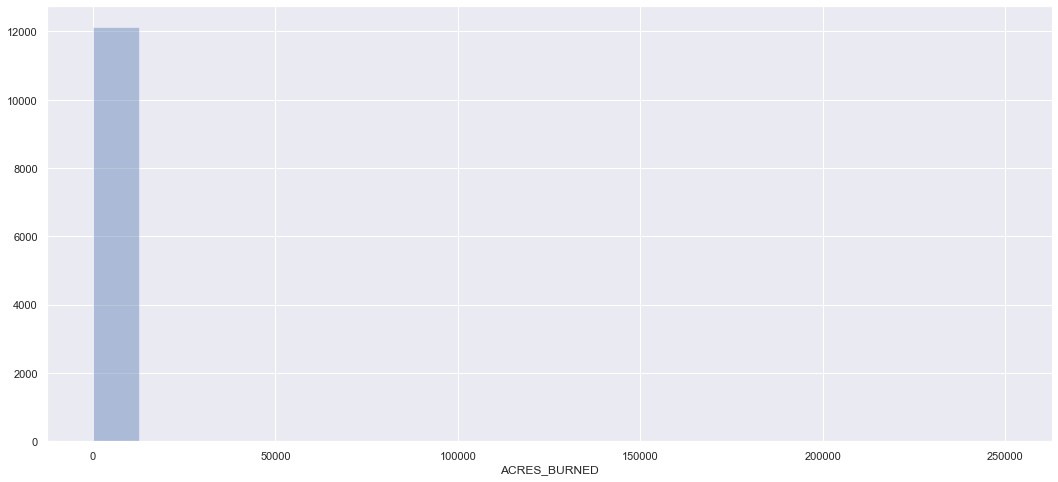

In [14]:
# Histogram of acres burned
# Mainly very small fires
# Heavy skew
plt.figure(figsize = (18,8))
dftest = df[df['ACRES_BURNED'] > 0]
sns.distplot(dftest.ACRES_BURNED, bins = 20, kde = False);

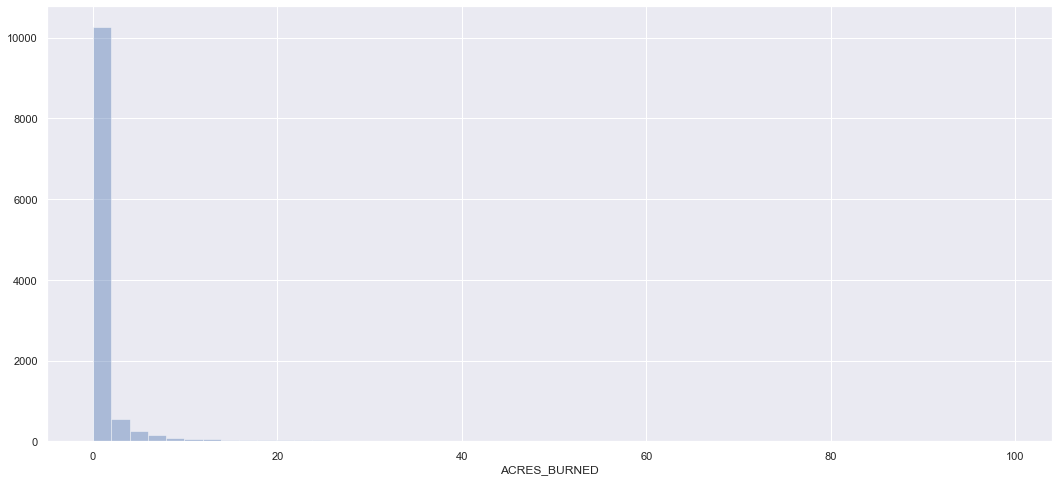

In [15]:
# Histogram of acres burned
# Mainly very small fires
plt.figure(figsize = (18,8))
dftest = df[df['ACRES_BURNED'] > 0]
dftest = dftest[dftest['ACRES_BURNED'] < 100]
sns.distplot(dftest.ACRES_BURNED, kde = False);

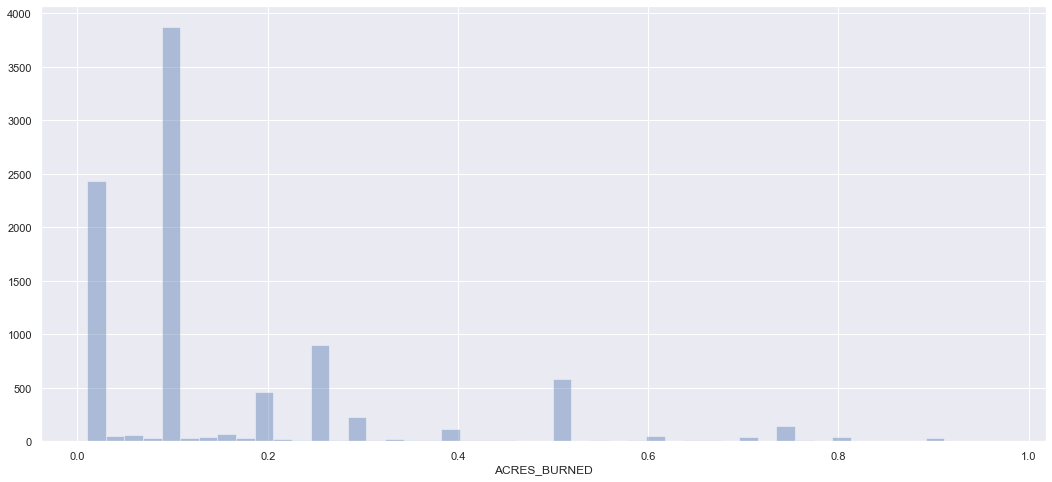

In [16]:
# Zooming in on fires under 1 acre
plt.figure(figsize = (18,8))
dftest = df[df['ACRES_BURNED'] > 0]
dftest = dftest[dftest['ACRES_BURNED'] < 1]
sns.distplot(dftest.ACRES_BURNED, kde = False);

From the above histograms, we can see that the majority of wildfires are between 0 and .1 acres.

In [17]:
# Maybe also try pins with small, med, and large as separate pin colors
wa_coord = (47.4, -120.7401)
# Creating an empty map
map = folium.Map(location = wa_coord, zoom_start = 7.3, tiles='Cartodb Positron')

# Adding markers:
from folium.plugins import HeatMap
HeatMap(data=df[['LAT_COORD', 'LON_COORD', 'ACRES_BURNED']].\
        groupby(['LAT_COORD', 'LON_COORD']).sum().reset_index().\
        values.tolist(), radius=11).add_to(map)

display(map)

The heat map above shows acres burned by wildfire.  The middle of the state has been hit the hardest.

In [18]:
df_small = df[df['ACRES_BURNED'] > 0]
df_small = df_small[df_small['ACRES_BURNED'] < 10]
df_med = df[df['ACRES_BURNED'] >= 10]
df_med = df_med[df_med['ACRES_BURNED'] < 500]
df_large = df[df['ACRES_BURNED'] >= 500]

df_small = df_small[:150]
df_med = df_med[:150]
df_large = df_large[:150]

In [19]:
wa_coord = (47.4, -120.7401)
# Creating an empty map
map = folium.Map(location = wa_coord, zoom_start = 7.3, tiles='Cartodb Positron')

# Adding markers:
# Small - Yellow
for i in range(0,len(df_small)):
    folium.CircleMarker([df_small.iloc[i]['LAT_COORD'], 
                         df_small.iloc[i]['LON_COORD']],
                         radius = 3,
                         color= 'yellow',
                         fill_color='white',
                         popup=df_small.iloc[i]['ACRES_BURNED']).add_to(map)
    
# Med - Orange    
for i in range(0,len(df_med)):
    folium.CircleMarker([df_med.iloc[i]['LAT_COORD'], 
                         df_med.iloc[i]['LON_COORD']],
                         radius = 3,
                         color= 'orange',
                         fill_color='white',
                         popup=df_med.iloc[i]['ACRES_BURNED']).add_to(map)
# Large - Red    
for i in range(0,len(df_large)):
    folium.CircleMarker([df_large.iloc[i]['LAT_COORD'], 
                         df_large.iloc[i]['LON_COORD']],
                         radius = 3,
                         color= 'red',
                         fill_color='white',
                         popup=df_large.iloc[i]['ACRES_BURNED']).add_to(map)
display(map)

Yellow: Small <br>
Orange: Medium <br>
Red: Large <br>

Most of the large fires are clustered around central Washington, with very few in the Spokane area.

## Map with Pins, Color by Date: 

In [20]:
print('Earliest Start Date: ', min(df.START_DT))
print('Latest Start Date: ', max(df.START_DT))

Earliest Start Date:  2000/07/21 08:00:00+00
Latest Start Date:  2020/09/23 08:00:00+00


In [21]:
# Most fires happening in July/Aug - no surprise
df.month.value_counts()

7     3978
8     3443
9     1745
6     1629
5      924
4      655
10     561
3      288
11      80
2       45
1       16
12      15
Name: month, dtype: int64

In [22]:
df_jul = df[df['month'] == 7]
df_aug = df[df['month'] == 8]
df_sept = df[df['month'] ==  9]
#df_other = df[df['month'] ==  [7,8,9]]
# Limiting Sample
df_jul = df_jul[:150]
df_aug = df_aug[:150]
df_sept = df_sept[:150]
#df_other = df_other[:150]

In [23]:
wa_coord = (47.4, -120.7401)
# Creating an empty map
map = folium.Map(location = wa_coord, zoom_start = 7.3, tiles='Cartodb Positron')

# df_jul
# df_aug
# df_sept
# Adding markers:
# July - Yellow
for i in range(0,len(df_jul)):
    folium.CircleMarker([df_jul.iloc[i]['LAT_COORD'], 
                         df_jul.iloc[i]['LON_COORD']],
                         radius = 3,
                         color= 'yellow',
                         fill_color='white',
                         popup=df_jul.iloc[i]['month']).add_to(map)
    
# Aug - Orange    
for i in range(0,len(df_aug)):
    folium.CircleMarker([df_aug.iloc[i]['LAT_COORD'], 
                         df_aug.iloc[i]['LON_COORD']],
                         radius = 3,
                         color= 'orange',
                         fill_color='white',
                         popup=df_aug.iloc[i]['month']).add_to(map)
# Sept - Red    
for i in range(0,len(df_sept)):
    folium.CircleMarker([df_sept.iloc[i]['LAT_COORD'], 
                         df_sept.iloc[i]['LON_COORD']],
                         radius = 3,
                         color= 'red',
                         fill_color='white',
                         popup=df_sept.iloc[i]['month']).add_to(map)
display(map)

Yellow: July<br>
Orange: August<br>
Red: September<br>

It looks like there's a cluster of late season fires around Spokane, while most of the mid/early season fires that are larger take place in central Washington.

## Map with Pins, Color by Cause:

In [24]:
print('Cause of Fires:\n\n',df.FIREGCAUSE_LABEL_NM.value_counts())

Cause of Fires:

 Misc            3354
Lightning       2624
Debris Burn     2266
Recreation      2001
Undetermined    1392
Under Invest     569
Arson            407
Children         334
Smoker           221
Logging          134
Railroad          77
Name: FIREGCAUSE_LABEL_NM, dtype: int64


In [25]:
df_lightning = df[df['FIREGCAUSE_LABEL_NM'] == 'Lightning']
df_arson = df[df['FIREGCAUSE_LABEL_NM'] == 'Arson']
df_debris = df[df['FIREGCAUSE_LABEL_NM'] == 'Debris Burn']
# Limiting Sample
df_lightning = df_lightning[:150]
df_arson = df_arson[:150]
df_debris = df_debris[:150]
###
df100 = df[:150]

In [26]:
wa_coord = (47.4, -120.7401)
# Creating an empty map
map = folium.Map(location = wa_coord, zoom_start = 7.3, tiles='Cartodb Positron')

# Lightning - Yellow
for i in range(0,len(df_lightning)):
    folium.CircleMarker([df_lightning.iloc[i]['LAT_COORD'], 
                         df_lightning.iloc[i]['LON_COORD']],
                         radius = 3,
                         color= 'yellow',
                         fill_color='white',
                         popup=df_lightning.iloc[i]['FIREGCAUSE_LABEL_NM']).add_to(map)
    
# Arson - Red    
for i in range(0,len(df_arson)):
    folium.CircleMarker([df_arson.iloc[i]['LAT_COORD'], 
                         df_arson.iloc[i]['LON_COORD']],
                         radius = 3,
                         color= 'red',
                         fill_color='white',
                         popup=df_arson.iloc[i]['FIREGCAUSE_LABEL_NM']).add_to(map)
# Debris - Blue    
for i in range(0,len(df_debris)):
    folium.CircleMarker([df_debris.iloc[i]['LAT_COORD'], 
                         df_debris.iloc[i]['LON_COORD']],
                         radius = 3,
                         color= 'blue',
                         fill_color='white',
                         popup=df_debris.iloc[i]['FIREGCAUSE_LABEL_NM']).add_to(map)

display(map)

Yellow: Lightening<br>
Blue: Debris<br>
Red: Arson<br>

There appears to be a cluster of arson around Spokane.  Worth keeping an eye on!

## Map by Date of Fire:

In [27]:
df.year.value_counts()

2018    1371
2009    1281
2015    1238
2019    1203
2020    1110
2017    1032
2014    1025
2008     991
2016     966
2012     941
2013     906
2010     648
2011     630
2003       6
2004       6
2001       6
2005       6
2007       5
2002       3
2006       3
2000       2
Name: year, dtype: int64

In [28]:
df_year = df.groupby(by=["year"]).sum()
df_month = df.groupby(by=["month"]).sum()
dfx = df[df['year'] > 2012]
df_date = dfx.groupby(by=["date"]).sum()


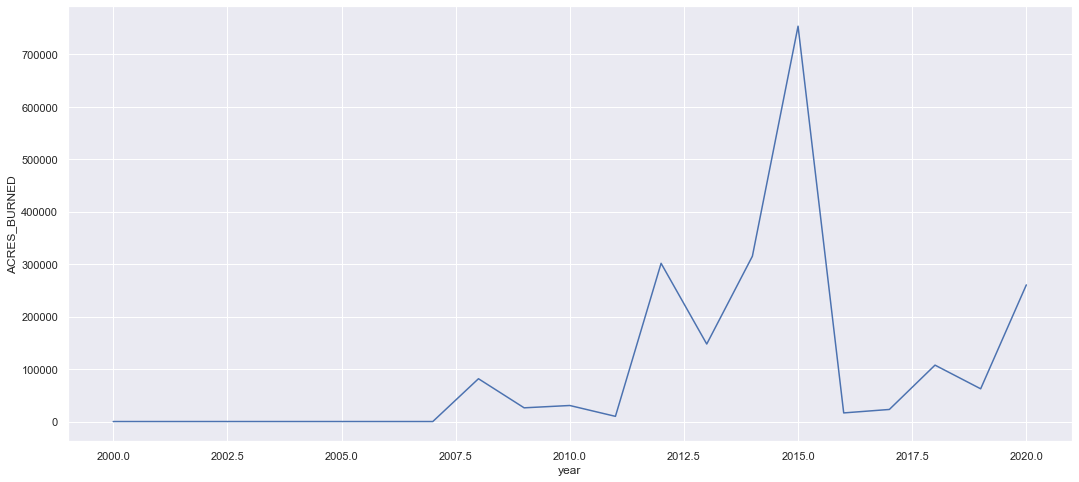

In [29]:
plt.figure(figsize = (18,8))
sns.lineplot(x="year", y="ACRES_BURNED",
             data=df_year)

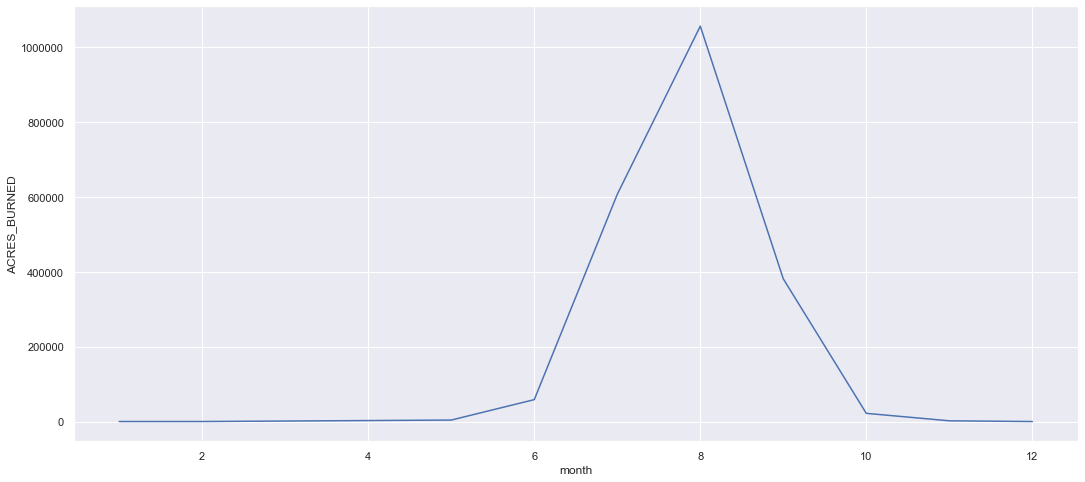

In [30]:
plt.figure(figsize = (18,8))
sns.lineplot(x="month", y="ACRES_BURNED",
             data=df_month)

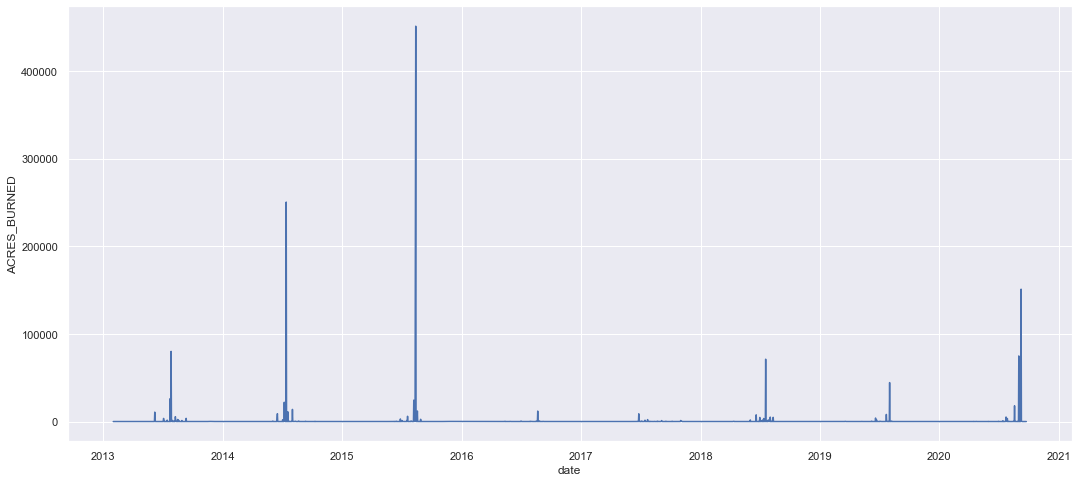

In [31]:
plt.figure(figsize = (18,8))
sns.lineplot(x="date", y="ACRES_BURNED",
             data=df_date)

# Neural Network (Baseline):

## Import Images:

In [32]:
# Paths - Mac:
# /Users/Thomas/Desktop/capstone/images/test_wf
# /Users/Thomas/Desktop/capstone/images/test_nwf
# Images should be 350x350

In [33]:
# Paths - Mac:
# Train
train_folder = '/Users/Thomas/Desktop/split/train'
train_wf = '/Users/Thomas/Desktop/split/train/wf'
train_nwf = '/Users/Thomas/Desktop/split/train/nwf'

# Test 
test_folder = '/Users/Thomas/Desktop/split/test'
test_wf = '/Users/Thomas/Desktop/split/test/wf'
test_nwf = '/Users/Thomas/Desktop/split/test/nwf'

# Validation
val_folder = '/Users/Thomas/Desktop/split/val'
val_wf = '/Users/Thomas/Desktop/split/val/wf'
val_nwf = '/Users/Thomas/Desktop/split/val/nwf'

In [34]:
# This is turning them into 64x64x3 images
# Will be adjusted for final version
# If it runs well, try to keep it at 350x350
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(256, 256), batch_size = 2000)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(256, 256), batch_size = 200) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(256, 256), batch_size = 200)

Found 4241 images belonging to 2 classes.
Found 272 images belonging to 2 classes.
Found 304 images belonging to 2 classes.


In [35]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [36]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 2000
Number of testing samples: 200
Number of validation samples: 200
train_images shape: (2000, 256, 256, 3)
train_labels shape: (2000, 2)
test_images shape: (200, 256, 256, 3)
test_labels shape: (200, 2)
val_images shape: (200, 256, 256, 3)
val_labels shape: (200, 2)


In [37]:
# Reshaping to 1d array:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(2000, 196608)
(200, 196608)
(200, 196608)


In [38]:
# Lablels for the images:
train_y = np.reshape(train_labels[:,0], (2000,1))
test_y = np.reshape(test_labels[:,0], (200,1))
val_y = np.reshape(val_labels[:,0], (200,1))

## Baseline Model: 
### (Basic Artificial Neural Network with Several Dense Layers)

In [39]:
# Graphs
def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (12,8)) 
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show

In [40]:
# Metrics
def model_metrics(model):
    train_acc = model.evaluate(train_img, train_y, verbose=0)
    test_acc = model.evaluate(test_img, test_y, verbose=0)
    print('Train Loss:', "{:.3%}".format(train_acc[0]))
    print('Train Accuracy:', "{:.3%}".format(train_acc[1]))
    print('Test Loss:', "{:.3%}".format(test_acc[0]))
    print('Test Accuracy:', "{:.3%}".format(test_acc[1]))

In [41]:
# First baseline model.  Standard dense layers.
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(196608,))) # 2 hidden layers
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [42]:
# Training the model
history = model.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Train on 2000 samples, validate on 200 samples
Epoch 1/50
2000/2000 [==============================] - 9s 4ms/step - loss: 0.7015 - acc: 0.5035 - val_loss: 0.6762 - val_acc: 0.6500
Epoch 2/50
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6943 - acc: 0.4980 - val_loss: 0.6935 - val_acc: 0.4800
Epoch 3/50
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6931 - acc: 0.5055 - val_loss: 0.6984 - val_acc: 0.3500
Epoch 4/50
2000/2000 [==============================] - 6s 3ms/step - loss: 0.6929 - acc: 0.5110 - val_loss: 0.6977 - val_acc: 0.3500
Epoch 5/50
2000/2000 [==============================] - 6s 3ms/step - loss: 0.6928 - acc: 0.5110 - val_loss: 0.7001 - val_acc: 0.3500
Epoch 6/50
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6927 - acc: 0.5110 - val_loss: 0.6974 - val_acc: 0.3450
Epoch 7/50
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6918 - acc: 0.5390 - val_loss: 0.6993 - val_acc: 0.3500
Epoch 8/50
2000

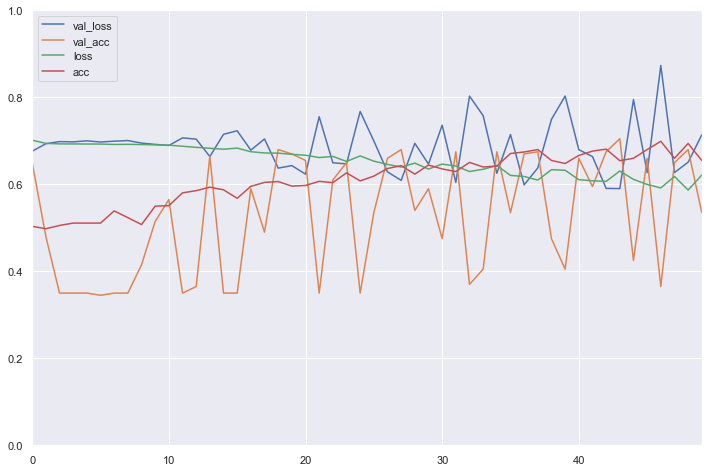

In [43]:
model_eval(history)

In [44]:
# A little better than guessing!
model_metrics(model)

Train Loss: 58.839%
Train Accuracy: 70.800%
Test Loss: 69.367%
Test Accuracy: 55.500%


# Conclusion:

This baseline model has a long way to go before I'm comfortable making predictions with it.  In my next notebook, I'll be redoing this process with a more powerful convolutional neural network.  I'll also use more images, and perform more robust analysis of the resulting network. Please check out the pc_cnn notebook for more info and a more robust neural network!

-TB